<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/csivava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Csivava vagy muffin?

Számos kép kering az interneten, melyen az ember is nehezen tud megkülönböztetni egy csivavát egy áfonyás maffintól. Nézzük meg, hogy a konvolúciós neurális hálózat hogyan boldogul ezzel a feladattal.

Összegyűjtöttünk 26 csivava és 26 áfonyás maffin képet az internetről.

A kép letöltése.

In [184]:
!wget -q -O cs_ma.jpg https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/cs_ma.jpg?raw=true

##Képek előkészítése

Az 52 darab 100x100 pixeles, csivava illetve maffin képet egyetlen képfájlba raktuk össze, 13 sorban és négy oszlopban.

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

Nézzük meg a képet!

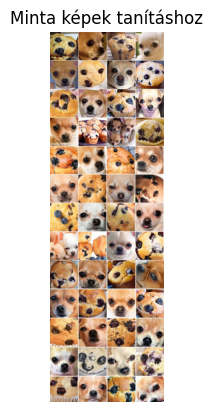

In [186]:
img = imread('cs_ma.jpg')
plt.axis("off")
plt.imshow(img, cmap='gray')
_ = plt.title("Minta képek tanításhoz")

##Előkészítés

A letöltött egy nagy képet szét kell darabolnunk és a kialakított kis képekhez a címkéket is elő kell állítanunk.

In [187]:
image_size = 50                 # a kis képek mérete (négyzetes), pixel
sample_start = 0                # ettől a sortól kell feldolgozni a mintákat
sample_rows = 13                # eddig a sorig kell feldolgozni a mintákat
sample_cols = 4                 # ennyi minta van egy sorban
sample_num = sample_rows * sample_cols  # összes minta száma
size = 100                      # minták szkennelt mérete, pixel
border = 0                      # vágási margó, pixel
labels = ["csivava", "maffin"]  # cimke nevek, 0-csivava, 1-maffin)
num_classes = len(labels)
lab = np.array([[1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0]
                ])

In [188]:
# tömbök létrehozása a bemenő adatoknak és a címkéknek
X = np.zeros((sample_num, image_size, image_size, 3, 1), dtype='float32')
y = lab.flatten()
# kis képek létrehozása
k = 0
for i in range(sample_start, sample_start + sample_rows):     # minden sorra
    pixel_top = i * size + border                             # sor felső pixele
    pixel_bot = (i + 1) * size - border                       # sor alsó pixele
    for j in range(sample_cols):                              # minden oszlopra
        pixel_left = j * size + border                        # oszlop bal széle pixel
        pixel_righ = (j + 1) * size - border                  # oszlop jobb széle pixel
        sub_img = img[pixel_top:pixel_bot,pixel_left:pixel_righ]
        # felbontás lecsökkentése
        X[k] = np.expand_dims(resize(sub_img, (image_size, image_size, 3)), -1)
        k += 1

Az előkészítés végén ellenőrizzük a kis képeket és a címkéket!

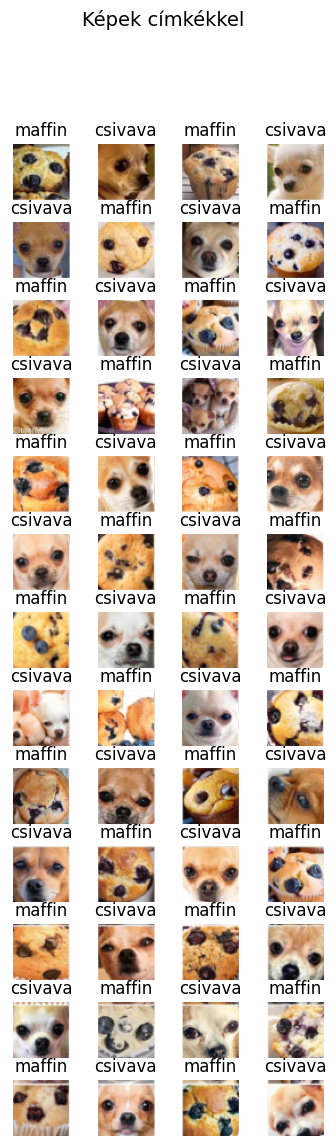

In [189]:
fig, ax = plt.subplots(sample_rows, sample_cols, figsize=(sample_cols, sample_rows))
fig.suptitle('Képek címkékkel', fontsize=14)
ax = ax.ravel()
for i in range(sample_num):
    ax[i].imshow(X[i,:,:,:,0])
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

##Tanítás

A tanítás soran a felcímkézett képeket tanító (80%) és teszt (20%) részre bontjuk szét. Emellett előkészítjük a Keras használatához.

In [190]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.metrics import binary_accuracy

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
y_orig_train = y_train.copy()
y_train = to_categorical(y_train, num_classes)      # címkék szükséges átalakítása Kerashoz
y_orig_test = y_test.copy()
y_test = to_categorical(y_test, num_classes)
filter_size = 3                                     # 3 x 3 konvolúciós szűrőket használunk

Egy egyszerű CNN modell hozunk létre.

In [192]:
model = Sequential()
# 4 db. 3 x 3 konvolúciós szűrő
model.add(Conv2D(4, (filter_size, filter_size), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))                 # kép méret felére csökkentése
model.add(Flatten())                            # kép vektorrá alakítása
model.add(Dropout(0.5))                         # súlyok véletlenszerű kihagyása 50%-ban
model.add(Dense(2, activation='softmax'))       # kimeneti réteg
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)     # hiper paraméterek
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 48, 48, 4)         112       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 24, 24, 4)         0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 2304)              0         
                                                                 
 dropout_37 (Dropout)        (None, 2304)              0         
                                                                 
 dense_21 (Dense)            (None, 2)                 4610      
                                                                 
Total params: 4722 (18.45 KB)
Trainable params: 4722 (18.45 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

A tanítást 30 iterációs lépésben végezzük el.

In [193]:
epochs = 30             # iterációk száma
batch_size = 12         # egyidejűleg feldolgozott minták száma
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/30
4/4 [==============================] - 1s 77ms/step - loss: 0.2692 - accuracy: 0.5610 - val_loss: 0.2631 - val_accuracy: 0.4545
Epoch 2/30
4/4 [==============================] - 0s 22ms/step - loss: 0.2855 - accuracy: 0.4390 - val_loss: 0.2460 - val_accuracy: 0.6364
Epoch 3/30
4/4 [==============================] - 0s 26ms/step - loss: 0.2761 - accuracy: 0.5366 - val_loss: 0.2451 - val_accuracy: 0.5455
Epoch 4/30
4/4 [==============================] - 0s 29ms/step - loss: 0.2235 - accuracy: 0.6341 - val_loss: 0.2427 - val_accuracy: 0.6364
Epoch 5/30
4/4 [==============================] - 0s 27ms/step - loss: 0.2187 - accuracy: 0.7073 - val_loss: 0.2356 - val_accuracy: 0.6364
Epoch 6/30
4/4 [==============================] - 0s 20ms/step - loss: 0.2112 - accuracy: 0.6585 - val_loss: 0.2273 - val_accuracy: 0.8182
Epoch 7/30
4/4 [==============================] - 0s 25ms/step - loss: 0.1910 - accuracy: 0.8049 - val_loss: 0.2131 - val_accuracy: 0.8182
Epoch 8/30
4/4 [===========

Nézzük meg a tanítás folyamatát!

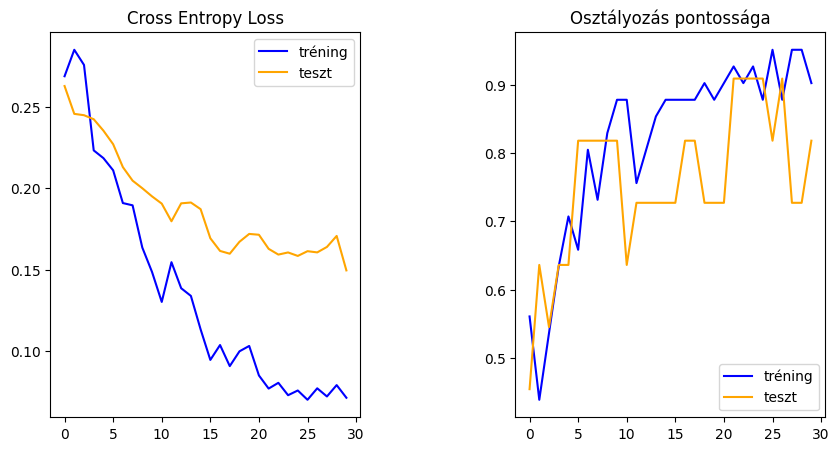

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(history.history['loss'], color='blue', label='tréning')
ax[0].plot(history.history['val_loss'], color='orange', label='teszt')
ax[0].legend()
# pontosság ábrázolása
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history.history['accuracy'], color='blue', label='tréning')
ax[1].plot(history.history['val_accuracy'], color='orange', label='teszt')
ax[1].legend(loc=4)
plt.subplots_adjust(wspace=0.5)

In [195]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(f"Pontosság teszt  adatokra: {np.sum(binary_accuracy(y_test, y_pred_test, threshold=0.5)) / y_pred_test.shape[0]:.1%}")
print(f"Pontosság tanító adatokra: {np.sum(binary_accuracy(y_train, y_pred_train, threshold=0.5)) / y_pred_train.shape[0]:.1%}")

2/2 [==============================] - 0s 9ms/step
Pontosság teszt  adatokra: 81.8%
Pontosság tanító adatokra: 100.0%


Nézzük meg, melyik teszt képet sikerült illetve nem sikerült jól besorolni. Piros színnel írjuk a fel a téves besorolásokat.

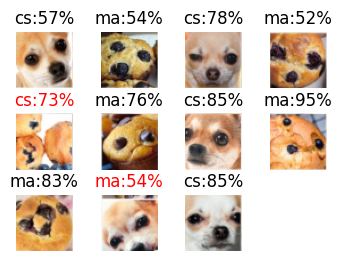

In [196]:
#y_pred_test = model.predict(X_test)
pred_test_classes = np.argmax(y_pred_test, axis=1)
fig, ax = plt.subplots(X_test.shape[0]//sample_cols+1, sample_cols, figsize=(sample_cols, X_test.shape[0]//sample_cols+1))
#fig.suptitle('Teszt képek', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cls = pred_test_classes[i]     # 0/1
    val = y_pred_test[i, cls]
    ax[i].imshow(X_test[i,:,:,:,0])
    color= 'black' if int(cls+0.5) == y_orig_test[i] else 'red'
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.0%}", c=color)
plt.subplots_adjust(wspace=0.5)

A képek feletti százalékos érték jelzi a besorolás valószínűségét. Sok esetben közel vagyünk az 50%-hoz. A modellünk nem túl magabiztosan, de zömében jól sorolta be az ellenőrző képeket.

Ismételjük meg a tanítástól a folyamatot! Vegye észre, hogy a megismételt futtatás eredménye nem azonos az előzővel, mivel véletlenszámoktól függ a tanítási folyamat.

Készítsünk egy összetettebb modell!

TODO

In [197]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(image_size,image_size,3)))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_56 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_56 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_57 (Ba  (None, 50, 50, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                     

In [198]:
epochs = 30             # iterációk száma
batch_size = 8          # egyidejűleg feldolgozott minták száma
history1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/30
6/6 [==============================] - 6s 221ms/step - loss: 1.2604 - accuracy: 0.5854 - val_loss: 0.7686 - val_accuracy: 0.4545
Epoch 2/30
6/6 [==============================] - 1s 146ms/step - loss: 0.6109 - accuracy: 0.6585 - val_loss: 1.0089 - val_accuracy: 0.4545
Epoch 3/30
6/6 [==============================] - 1s 150ms/step - loss: 0.6707 - accuracy: 0.7805 - val_loss: 1.2340 - val_accuracy: 0.4545
Epoch 4/30
6/6 [==============================] - 1s 151ms/step - loss: 0.4752 - accuracy: 0.8049 - val_loss: 1.3821 - val_accuracy: 0.4545
Epoch 5/30
6/6 [==============================] - 1s 149ms/step - loss: 0.3744 - accuracy: 0.8293 - val_loss: 1.5506 - val_accuracy: 0.4545
Epoch 6/30
6/6 [==============================] - 1s 148ms/step - loss: 0.1265 - accuracy: 0.9268 - val_loss: 1.6591 - val_accuracy: 0.4545
Epoch 7/30
6/6 [==============================] - 1s 148ms/step - loss: 0.1928 - accuracy: 0.8780 - val_loss: 1.9139 - val_accuracy: 0.4545
Epoch 8/30
6/6 [====

In [199]:
y_pred1_test = model1.predict(X_test)
y_pred1_train = model1.predict(X_train)
print(f"Pontosság teszt  adatokra: {np.sum(binary_accuracy(y_test, y_pred1_test, threshold=0.5)) / y_pred1_test.shape[0]:.1%}")
print(f"Pontosság tanító adatokra: {np.sum(binary_accuracy(y_train, y_pred1_train, threshold=0.5)) / y_pred1_train.shape[0]:.1%}")

2/2 [==============================] - 0s 42ms/step
Pontosság teszt  adatokra: 45.5%
Pontosság tanító adatokra: 51.2%


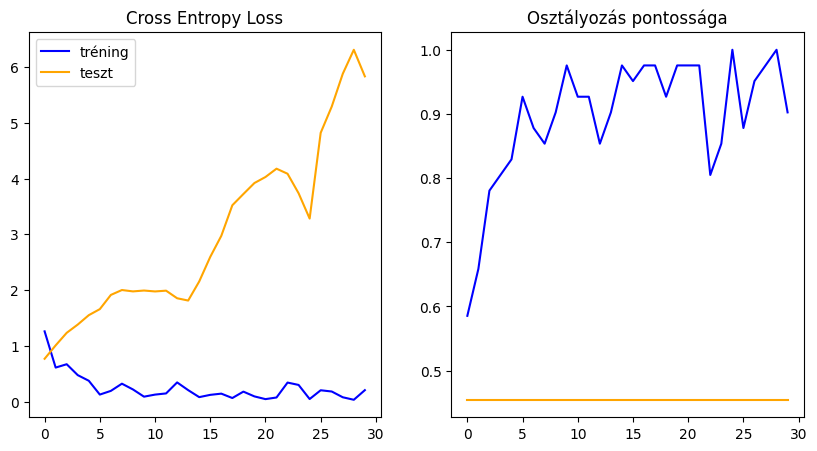

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(history1.history['loss'], color='blue', label='tréning')
ax[0].plot(history1.history['val_loss'], color='orange', label='teszt')
ax[0].legend()
# pontosság ábrázolása
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history1.history['accuracy'], color='blue', label='tréning')
ax[1].plot(history1.history['val_accuracy'], color='orange', label='teszt')
ax[0].legend()